## Testing the different models

- Naive Forecast (done)
- SARIMA (done)
- LSTM (in progress)
- XGBoost (to implement)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from river_forecast.training_data_access import get_combined_flow_split

In [3]:
train, validation, test = get_combined_flow_split()

Text(0, 0.5, 'Flow')

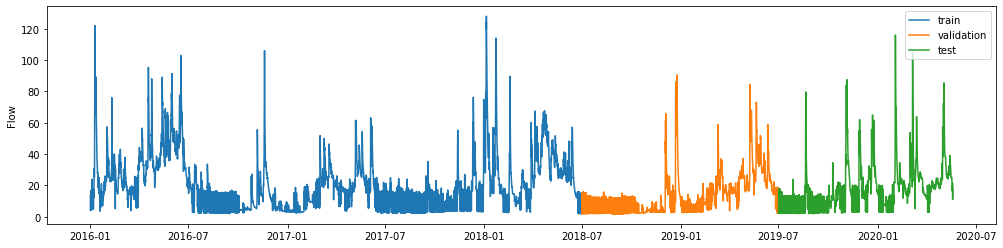

In [4]:
fig, ax = plt.subplots(figsize=(17, 4))
ax.plot(train, label='train')
ax.plot(validation, label='validation')
ax.plot(test, label='test')
ax.legend()
ax.set_ylabel('Flow')

In [5]:
from river_forecast.forecast import SARIMAXForecast, NaiveForecast, LSTMForecast, LSTMSeq2SeqForecast, XGBForecast

In [6]:
nf = NaiveForecast()
sf = SARIMAXForecast()
lstm = LSTMForecast()
lstm2 = LSTMSeq2SeqForecast()
bst = XGBForecast()

[16:12:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:12:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

In [7]:
lstm2.dynamic_forecast(test.iloc[0:1])

2019-07-01 02:00:00    11.314008
2019-07-01 03:00:00     5.204216
2019-07-01 04:00:00     4.890938
2019-07-01 05:00:00     5.072639
2019-07-01 06:00:00     5.368979
2019-07-01 07:00:00     5.618685
Freq: H, dtype: float32

In [8]:
input_length = 72
forecast_length = int(6)
n_possible_forecasts = len(validation) - input_length + 1 - forecast_length
n_forecasts = 500 # n_possible_forecasts


In [44]:
forecasts = np.zeros((5, n_forecasts, forecast_length))
real_values = np.zeros((n_forecasts, forecast_length))
real_recent_flows = np.zeros((n_forecasts, 12))
np.random.seed(5)
for i, j in enumerate(np.random.choice(n_possible_forecasts, size=n_forecasts, replace=False)):
    if i%5 == 0:
        print(i, 'out of', n_possible_forecasts)
    recent_flow = validation.iloc[j:(j + input_length)]
    real_recent_flows[i, :] = recent_flow.iloc[-12:]['discharge']
    real_values[i, :] = validation.iloc[(j + input_length):(j + input_length + forecast_length)]['discharge']
    forecasts[4, i, :] = bst.dynamic_forecast(recent_flow, n_hours=forecast_length)
    # forecasts[3, i, :] = lstm2.dynamic_forecast(recent_flow, n_hours=forecast_length)
    # forecasts[2, i, :] = lstm.dynamic_forecast(recent_flow, n_hours=forecast_length)
    forecasts[1, i, :] = sf.dynamic_forecast(recent_flow, n_hours=forecast_length)
    forecasts[0, i, :] = nf.dynamic_forecast(recent_flow, n_hours=forecast_length)

0 out of 8682
5 out of 8682
10 out of 8682
15 out of 8682
20 out of 8682
25 out of 8682
30 out of 8682
35 out of 8682
40 out of 8682
45 out of 8682
50 out of 8682
55 out of 8682
60 out of 8682
65 out of 8682
70 out of 8682
75 out of 8682
80 out of 8682
85 out of 8682
90 out of 8682
95 out of 8682
100 out of 8682
105 out of 8682
110 out of 8682
115 out of 8682
120 out of 8682
125 out of 8682
130 out of 8682
135 out of 8682
140 out of 8682
145 out of 8682
150 out of 8682
155 out of 8682
160 out of 8682
165 out of 8682
170 out of 8682
175 out of 8682
180 out of 8682
185 out of 8682
190 out of 8682
195 out of 8682
200 out of 8682
205 out of 8682
210 out of 8682
215 out of 8682
220 out of 8682
225 out of 8682
230 out of 8682
235 out of 8682
240 out of 8682
245 out of 8682
250 out of 8682
255 out of 8682
260 out of 8682
265 out of 8682
270 out of 8682
275 out of 8682
280 out of 8682
285 out of 8682
290 out of 8682
295 out of 8682
300 out of 8682
305 out of 8682
310 out of 8682
315 out of 868

In [11]:
maes = np.mean(np.abs(forecasts - real_values[np.newaxis, ...]), axis=1)

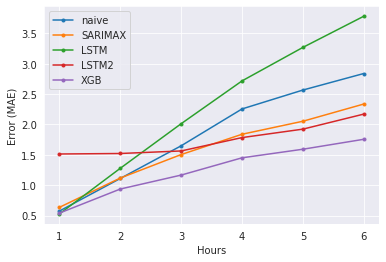

In [52]:
fig, ax = plt.subplots()
ax.plot(np.arange(forecast_length) + 1, maes[0], marker='.', label='naive')
ax.plot(np.arange(forecast_length) + 1, maes[1], marker='.', label='SARIMAX')
ax.plot(np.arange(forecast_length) + 1, maes[2], marker='.', label='LSTM')
ax.plot(np.arange(forecast_length) + 1, maes[3], marker='.', label='LSTM2')
ax.plot(np.arange(forecast_length) + 1, maes[4], marker='.', label='XGB')

ax.set_ylabel('Error (MAE)')
ax.set_xlabel('Hours')
ax.legend()

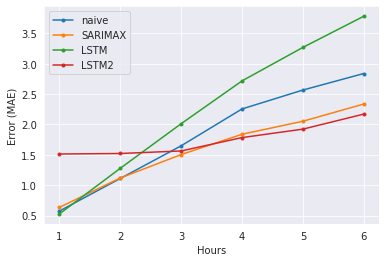

In [47]:
fig, ax = plt.subplots()
ax.plot(np.arange(forecast_length) + 1, maes[0], marker='.', label='naive')
ax.plot(np.arange(forecast_length) + 1, maes[1], marker='.', label='SARIMAX')
ax.plot(np.arange(forecast_length) + 1, maes[2], marker='.', label='LSTM')
ax.plot(np.arange(forecast_length) + 1, maes[3], marker='.', label='LSTM2')

ax.set_ylabel('Error (MAE)')
ax.set_xlabel('Hours')
# ax.set_xlim([0.9, 6.1])
# ax.set_ylim([0, 3.5])
ax.legend()

In [17]:
rmses = np.sqrt(np.mean((forecasts - real_values[np.newaxis, ...])**2, axis=1))

Text(0.5, 0, 'Hours')

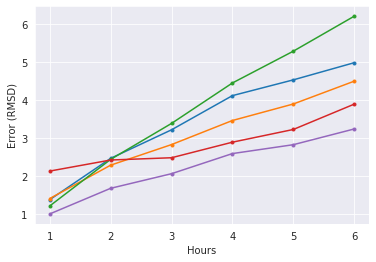

In [48]:
fig, ax = plt.subplots()
ax.plot(np.arange(forecast_length) + 1, rmses[0], marker='.', label='naive')
ax.plot(np.arange(forecast_length) + 1, rmses[1], marker='.', label='SARIMAX')
ax.plot(np.arange(forecast_length) + 1, rmses[2], marker='.', label='LSTM')
ax.plot(np.arange(forecast_length) + 1, rmses[3], marker='.', label='LSTM2')
ax.plot(np.arange(forecast_length) + 1, rmses[4], marker='.', label='XGB')
ax.set_ylabel('Error (RMSD)')
ax.set_xlabel('Hours')

#### Plotting example curves

In [25]:
forecasts[4, 0, :]

array([ 2.34384727,  2.734308  ,  3.5160141 ,  7.64025545, 12.74738884,
       12.75605106])

In [26]:
real_values[0]

array([ 2.22,  2.23,  2.25,  3.5 ,  9.28, 12.3 ])

In [29]:
real_recent_flows[0]

array([2.19, 2.14, 2.14, 2.14, 2.14, 2.14, 2.14, 2.15, 2.16, 2.18, 2.19,
       2.21])

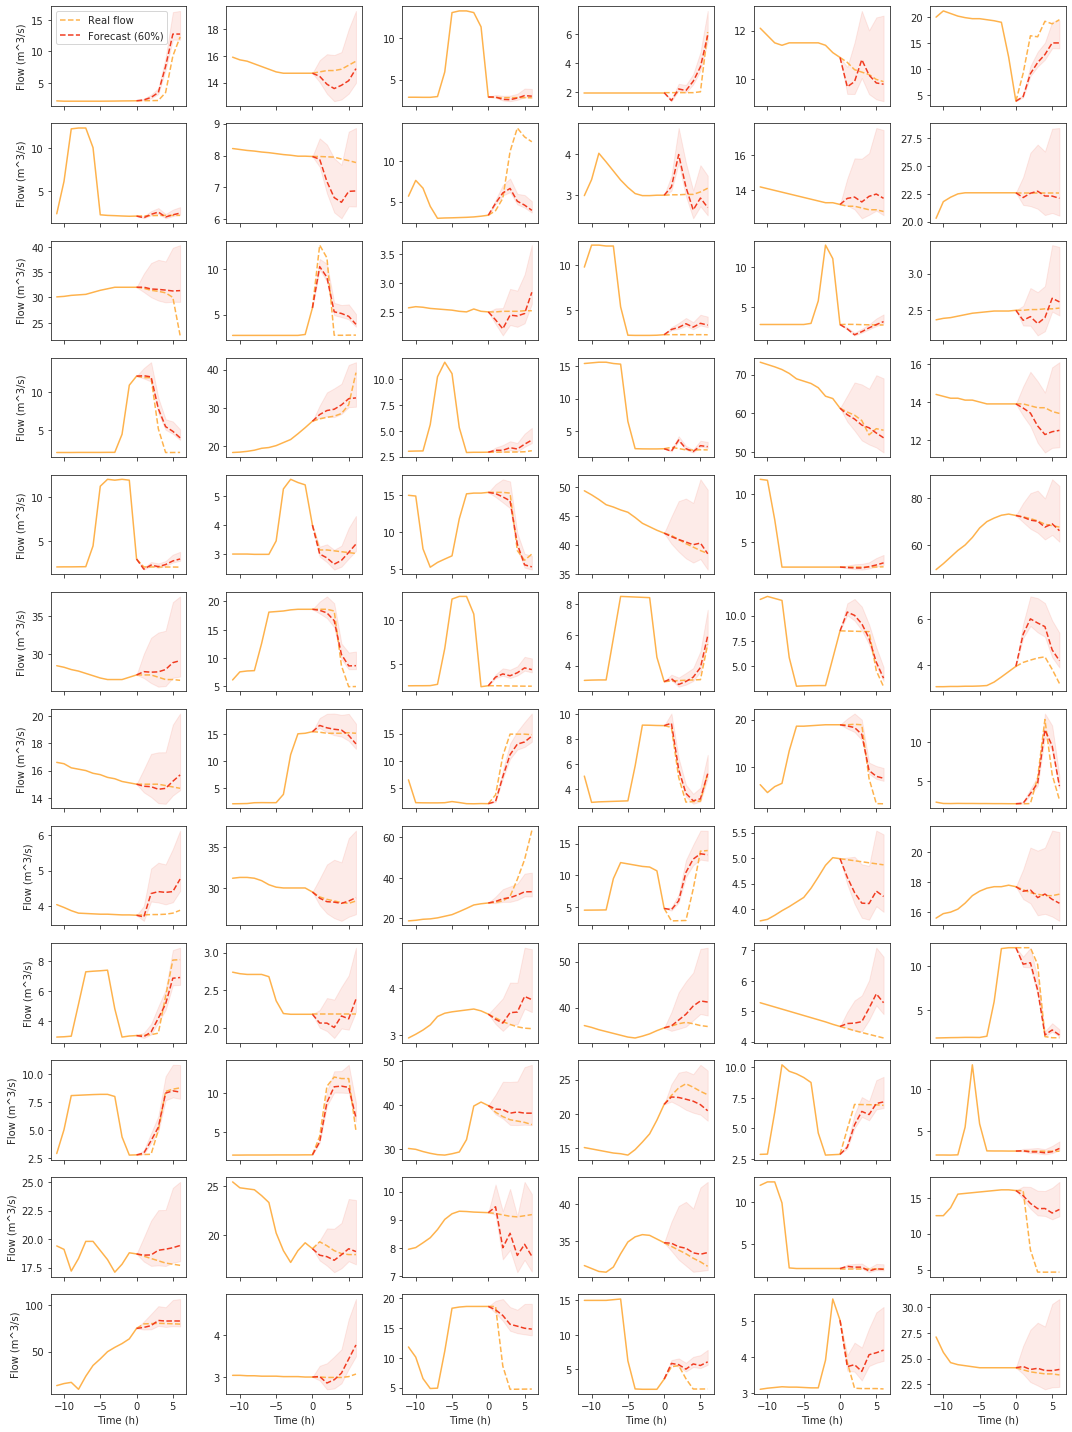

In [122]:
sns.set_style('ticks')

errors = forecasts[4, :, :] / real_values[:, :]

negative_ci = np.insert(np.percentile(errors, 20, axis=0), 0, 1)
positive_ci = np.insert(np.percentile(errors, 80, axis=0), 0, 1)

fig, axs = plt.subplots(12, 6, figsize=(15, 20), sharex=True)
colors = ['#feb24c','#f03b20']
for i, ax in enumerate(axs.flatten()):
    last_value = real_recent_flows[i, -1]
    ax.plot(np.arange(-11, 1), real_recent_flows[i, :], color=colors[0])
    ax.plot(np.arange(0, 7), np.insert(real_values[i, :], 0, last_value), color=colors[0], linestyle='--', label='Real flow')
    
    pred = np.insert(forecasts[4, i, :], 0, last_value)
    ax.plot(np.arange(0, 7), pred, color=colors[1], linestyle='--', label='Forecast (60%)')

    ax.fill_between(np.arange(0, 7), pred * negative_ci , pred * positive_ci, color=colors[1],
                   alpha=0.1)
    
for ax in axs[-1, :]:
    ax.set_xlabel('Time (h)')
for ax in axs[:, 0]:
    ax.set_ylabel('Flow (m^3/s)')
axs[0, 0].legend()
plt.tight_layout()

In [84]:
def boot_strap_confidence_interval():
    

SyntaxError: unexpected EOF while parsing (<ipython-input-84-d420b66b0289>, line 2)

In [112]:
errors = forecasts[4, :, :] / real_values[:, :]

In [113]:
errors.shape

(500, 6)

([array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  17., 455.,
          26.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  25., 421.,
          40.,  10.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  30., 400.,
          49.,  13.,   3.,   3.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.]),
  array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,  33., 396.,
          41.,  17.,   7.,   5.,  

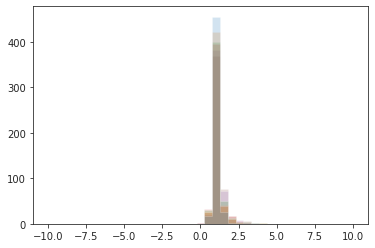

In [114]:
plt.hist(errors, histtype='stepfilled', alpha=0.2, bins=np.linspace(-10, 10, 40))

In [115]:
np.percentile(errors, 10, axis=0)

array([0.91769777, 0.88930711, 0.85962269, 0.84952607, 0.85190635,
       0.84709263])

In [116]:
np.percentile(errors, 90, axis=0)

array([1.18863873, 1.29977555, 1.39802401, 1.40740266, 1.48054915,
       1.48368537])